# Perfect-model predictability Module Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

# What's a perfect-model framework simulation?

Technically:
- a set of ensemble simulations based on an Earth-System-Model alone
- no assimilation of any reanalysis or data product interfers with the model
- any number of `members` are initialized from perturbed initial conditions is called `ensemble` (often the ensemble initialized in `1955`)
- the control simulation can be viewed as just another member

How to compare predictability skill score:
- As no observational data interfers with the random climate evolution of the model, we cannot use a observation-based reference.
- Therefore we can compare the members with each other (`m2m`) or against the ensemble mean (`m2e`) or the control (`m2c`) or the ensemble mean against the control (`e2c`).

When to use:
- you don't have a sufficiently long of observational records to use as a `reference`
- you want to aviod biases between model climatology and reanalysis climatology
- you want to aviod super sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation
- you want to delve into process understanding of predictability of a model without outside artefacts

How does it look like?
[See 4.2](#timeseries)

---

Some papers including perfect-model simulations:
- Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
- Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
- Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.
- Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
- Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
- Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 

---
**This demo:**

Input:
- 1-dimensional xr.Dataset timeseries output
- 3-dimensional xr.DataArray maps output

Shows:
- skill score
- predictability horizon
- slow components of internal variability indicating potential predictability:
 - DPP
 - variance-weighted mean period
 - decorrelation time
---

In [1]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model, 
                                 xr_predictability_horizon, 
                                 compute_persistence_pm)
from climpred.bootstrap import bootstrap_perfect_model, _pseudo_ens
from climpred.loadutils import get_datasets, open_dataset

from climpred.stats import (xr_decorrelation_time, xr_varweighted_mean_period, 
                           xr_autocorr, DPP)
%matplotlib inline

# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

## 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **ensemble**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [2]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

### Choose varname, area, period

In [3]:
varname='tos'
area='global'
period='ym'

In [4]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

# Bootstrap with replacement
Goddard et al. 2013

In [5]:
sig = 95
pers_sig = 95
bootstrap = 50 
comparison='m2e'

init_skill = compute_perfect_model(ds_, control_, metric='pearson_r', 
                                   comparison=comparison)
ds_uninit = _pseudo_ens(ds_, control_)
uninit_skill = compute_perfect_model(ds_uninit, control_, metric='pearson_r', 
                                     comparison=comparison).mean('time')
result = bootstrap_perfect_model(ds_, control_, metric='pearson_r', 
                                 comparison=comparison, bootstrap=bootstrap, 
                                 sig=sig, compute_persistence_skill=True)

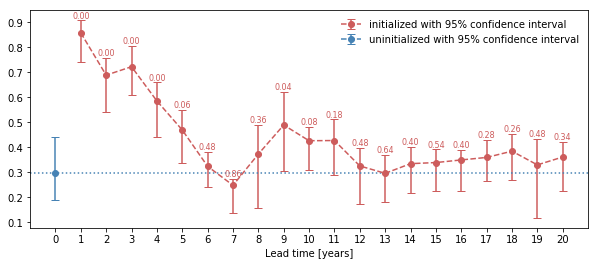

In [7]:
from climpred.graphics import plot_bootstrapped_skill_over_leadyear
plot_bootstrapped_skill_over_leadyear(init_skill,
                                      result.init_ci,
                                      uninit_skill,
                                      result.uninit_ci,
                                      sig,
                                      p_uninit_over_init=result.p_uninit_over_init)


### Proposal to reduce returned objects
sig and pers_sig can be obtained from pers.isel(results=1).results.values

this would reduce bootstrap_perfect_model to return init, uninit, pers, where the later have also pvalues

In [8]:
pers_skill = compute_persistence_pm(ds_, control_, 20)

In [9]:
p_pers_over_init=p_pers_over_init.expand_dims('quantile')
p_pers_over_init['quantile']=['p']
pers_skill=pers_skill.expand_dims('quantile')
pers_skill['quantile']=['skill']
pers=xr.merge([pers_skill, pers_ci,p_pers_over_init]).rename({'quantile':'results'})
pers.drop(['area','period'])

NameError: name 'p_pers_over_init' is not defined

### How does a perfect-model framework simulation look like?

<a id='timeseries'></a>

In [ ]:
def _get_limit_sig(metric='pearson_r',sig=99):
    """Adjust limit and significance level for bootstrapping to metric."""
    if metric in ['pearson_r', 'ppp', 'msss', 'nrmse', 'nmse']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

def _plot_skill(ax, result, color='k', linestyle='-', marker='o', 
                markersize=6, linewidth=2, **kwargs):
    """
    Quick function to plot results of predictability analysis.
    """
    p = ax.plot(result.time, result, color=color, linestyle=linestyle, 
                marker=marker, markersize=markersize, linewidth=linewidth, 
                **kwargs)
    return p

In [ ]:
comparison='m2e'
sig=99
bootstrap=100
# Main plot.
metrics = ['pearson_r', 'rmse', 'mse', 'ppp', 'nrmse','nmse']
f, axs = plt.subplots(nrows=len(metrics), ncols=1,figsize=(8,12))

for ax, metric in zip(axs, metrics):
    ip = compute_perfect_model(ds_, control_, metric=metric, comparison=comparison)
    limit, sigl = _get_limit_sig(metric=metric, sig=sig)
    up = bootstrap_perfect_model(ds_, control_, metric=metric, comparison=comparison, sig=sigl).values
    if metric in ['rmse', 'mse', 'pearson_r']:
        persist = compute_persistence(control_, dim='time', nlags=ds_.time.size, metric=metric)
        persist['time'] = persist['time']
        p = _plot_skill(ax, persist, color='gray', linestyle='--', label='persistence forecast')
    i = _plot_skill(ax, ip, color='r', label='initialized forecast')
    u = ax.axhline(y=up, color='blue', linewidth=1.5, label='uninitialized forecast')
    # predictability horizon
    ph = xr_predictability_horizon(ip, up, limit=limit, perfect_model=True).values
    php = ax.axvline(x=ph, color='blue', alpha=.5, ls='-.', label='predictability horizon')

    fac = 1.1
    #ax.set_ylim([fac * min(0, up, ip.min('time'),persist.min('time')),fac * max(up, ip.max('time'),persist.max('time'))])
    ax.set_xlim([0.8, 10.2])
    ax.set_xticks(np.arange(1.,11.),minor=False)
    ax.set_ylabel(metric)
    persist=persist-persist

plt.suptitle('Perfect-model potential Predictability global SST')

plt.legend([i[0], p[0], u, php],ncol=2)
plt.tight_layout()

## Different comparisons lead to different skill score magnitude by design

In [ ]:
for c in ['e2c','m2c','m2e','m2m']:
    compute_perfect_model(ds_, control_, metric='pearson_r', comparison=c).plot(label=c)
compute_persistence(control_,nlags=20, dim='time').plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r \n lead to systematically different magnitude of skill score')
plt.show()

Can we adapt persistence forecast to the references? What's a fair comparison for persistence?

# 3-dimensional

## 3-dimensional output
Data is stored on curvilinear grid: lon(y, x), lat(y, x)

In [ ]:
ds3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds3d.nc')
control3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control3d.nc')

## Choose predictability metric and comparison

In [ ]:
metric='pearson_r'
comparison='m2e'
sig=99
bootstrap=10
limit, sigl = _get_limit_sig(metric=metric, sig=sig)

## Skill for Lead Year

In [ ]:
skill3d = compute_perfect_model(ds3d[varname], control3d[varname], metric=metric, comparison=comparison)

In [ ]:
skill3d.plot(robust=True,yincrease=False, col='time')

## Bootstrapped threshold and Predictability Horizon map

In [ ]:
threshold3d = bootstrap_perfect_model(ds3d[varname], control3d[varname], metric=metric, comparison=comparison, 
                     sig=sigl, bootstrap=bootstrap)
# threshold3d.plot(robust=True,yincrease=False)

In [ ]:
if limit == 'upper':
    masked3d = skill3d.where(skill3d > threshold3d)
elif limit == 'lower':
    masked3d = skill3d.where(skill3d < threshold3d)

#masked3d.plot(yincrease=False, col='time')
#plt.suptitle('Skill score if above threshold')

In [ ]:
ph3d = xr_predictability_horizon(masked3d, threshold3d, limit=limit, perfect_model=True)
ph3d.name = 'Lead Years'

ph3d.where(ph3d>0).plot(robust=False,yincrease=False)
plt.title('Predictability Horizon '+varname)

## Persistence
Plot skill where larger than persistence.

In [ ]:
persistence_skill3d = compute_persistence(control3d[varname], nlags=ds3d.time.size,metric=metric, dim='time')
beat_persistence = skill3d.where(skill3d>persistence_skill3d)
beat_persistence.plot(col='time',yincrease=False)

# Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances of predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

## DPP

In [ ]:
help(DPP)

### Resplandy 2015, Seferian 2018 method

In [ ]:
DPP10 = DPP(control3d[varname], m=10, chunk=False)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

### Original Boer 2004 implementation

In [ ]:
DPP10 = DPP(control3d[varname], m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

yields similar results

## varweigthed mean period

In [ ]:
help(xr_varweighted_mean_period)

In [ ]:
from climpred.stats import xr_varweighted_mean_period as xvmp
varweighted_mean_period = xvmp(control3d[varname],time_dim='time')
varweighted_mean_period.plot(yincrease=False)

## Lag1 autocorrelation

In [ ]:
help(xr_autocorr)

In [ ]:
corr_ef = xr_autocorr(control3d[varname],dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

## Decorrelation time

In [ ]:
help(xr_decorrelation_time)

In [ ]:
decorr_time = xr_decorrelation_time(control3d[varname])
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)